# <div align="center">Wiki Traffic Forecast</div>
---------------------------------------------------------------------

you can Find me on Github:
> ###### [ GitHub](https://github.com/lev1khachatryan)

<img src="Pics/main_theme.png" />

 <a id="top"></a> <br>
## Content
1. [Problem Definition](#1)
  
  
2. [Data Preparation](#2)
  
    1. [Import Packages](#21)
    1. [Data Collection](#22)
  
  
3. [Exploratory data analysis](#3)  

    1. [Stationarity](#31)
    1. [Autocorrelation plots (ACF & PACF)](#32)
    1. [Properties and types of series](#33)
  
  
4. [Model Deployment](#4)
    1. [Train - Test](#41)
    1. [ARIMA](#42)
    1. [Markov Swithing](#43)

<a id="1" ></a> <br>
## <div align="center">1. Problem Definition</div>
---------------------------------------------------------------------

[go to top](#top)

This challenge is about predicting the future behaviour of time series’ that describe the web traffic for Wikipedia articles. The data contains about 145k time series. We will do forecating for only one page "Main_page"

<a id="2" ></a> <br>
## <div align="center">2. Data Preparation</div>
---------------------------------------------------------------------

[go to top](#top)

<a id="21" ></a> <br>
### <div>Import Packages</div>
---------------------------------------------------------------------

[go to top](#top)

In [1]:
'''
Data Loading and manipulation
'''
import pandas as pd
import numpy as np
import re
from collections import Counter
from datetime import datetime, timedelta

'''
Data Visualization
'''
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

'''
Missing value visualization
'''
import missingno as msno


'''
Modeling
'''
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

'''
Suppress warnings
'''
import warnings
warnings.filterwarnings('ignore')


<a id="22" ></a> <br>
### <div>Data Collection</div>
---------------------------------------------------------------------

[go to top](#top)

In [3]:
'''
Load data from disk and delete unused columns i f exists
'''

train = pd.read_csv('Data/train.csv', index_col = False).fillna(0)
if 'Unnamed: 0' in train.columns:
    train.drop(columns=['Unnamed: 0'], inplace  =True)
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18,11,5,13,14,9,9,22,26,...,32,63,15,26,14,20,22,19,18,20
1,2PM_zh.wikipedia.org_all-access_spider,11,14,15,18,11,13,22,11,10,...,17,42,28,15,9,30,52,45,26,20
2,3C_zh.wikipedia.org_all-access_spider,1,0,1,1,0,4,0,3,4,...,3,1,1,7,4,4,6,3,4,17
3,4minute_zh.wikipedia.org_all-access_spider,35,13,10,94,4,26,14,9,11,...,32,10,26,27,16,11,17,19,10,11
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0,0,0,0,0,0,0,0,0,...,48,9,25,13,3,11,27,13,36,10


In [4]:
page = train.iloc[21:22,:]
dates = page.columns[1:-1]
dates = '\"' + dates + '\"'
dates = [datetime.strptime(date, '"%Y-%m-%d"').date() for date in dates]
data = page.iloc[:, 1:-1].values[0]

'''
save page name to the variable
'''
page_name = page.iloc[:, 0:1].values[0]

'''
Create appropreate dateframe
'''
df = pd.DataFrame(
    {'Dates': dates,
    'Data': data
    }
)
df.index = df.Dates
df.drop(columns=['Dates'], inplace=True)
df.index = pd.to_datetime(df.index)
df.to_csv('page.csv')
print(df.head())

            Data
Dates           
2015-07-01    25
2015-07-02     3
2015-07-03     3
2015-07-04     4
2015-07-05    12


In [5]:
df.head()

,Data
Dates,
2015-07-01,25
2015-07-02,3
2015-07-03,3
2015-07-04,4
2015-07-05,12


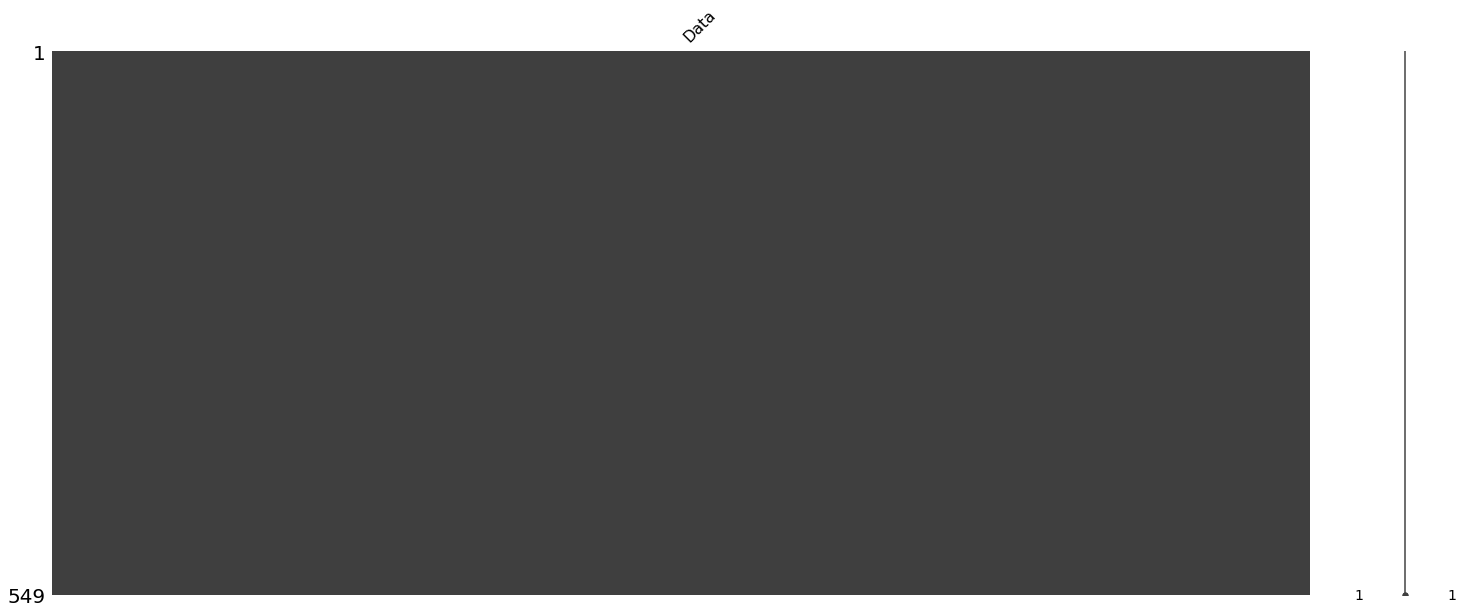

In [6]:
'''
Check if exist missing values
'''
msno.matrix(df)
plt.show()

In [7]:
df.isnull().sum()

Data    0
dtype: int64

<a id="3" ></a> <br>
## <div align="center">3. Exploratory data analysis</div>
---------------------------------------------------------------------

[go to top](#top)

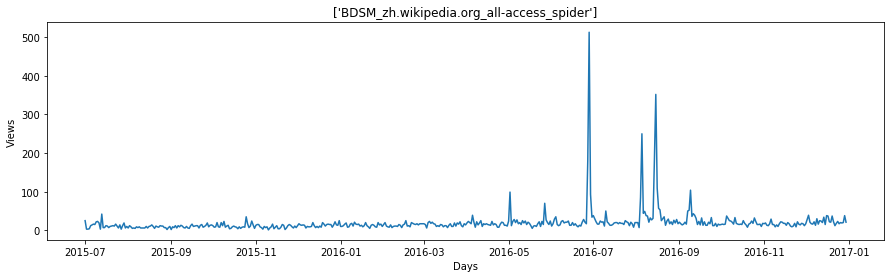

In [8]:
fig = plt.figure(1,figsize=(15,4))

plt.plot(dates, data)
plt.xlabel('Days')
plt.ylabel('Views')
plt.title(page_name)
plt.show()

<a id="31" ></a> <br>
## <div>Stationarity</div>
---------------------------------------------------------------------

[go to top](#top)

### <font color='red'>Augmented Dickey-Fuller Test </font>
This test is used to assess whether or not a time-series is stationary. Without getting into too much details about hypothesis testing, you should know that this test will give a result called a “test-statistic”, based on which you can say, with different levels (or percentage) of confidence, if the time-series is stationary or not

In [9]:
print(" > Is the data stationary ?")
dftest = adfuller(df.Data.values, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    


 > Is the data stationary ?
Test statistic = -4.776
P-value = 0.000
Critical values :
	1%: -3.4425861905056556 - The data is  stationary with 99% confidence
	5%: -2.8669372502674824 - The data is  stationary with 95% confidence
	10%: -2.5696445454608505 - The data is  stationary with 90% confidence


<a id="32" ></a> <br>
## <div>Autocorrelation plots (ACF & PACF)</div>
---------------------------------------------------------------------

[go to top](#top)

An autocorrelation (ACF) plot represents the autocorrelation of the series with lags of itself. 
A partial autocorrelation (PACF) plot represents the amount of correlation between a series and a lag of itself that is not explained by correlations at all lower-order lags.
Ideally, we want no correlation between the series and lags of itself. Graphically speaking, we would like all the spikes to fall in the blue region.

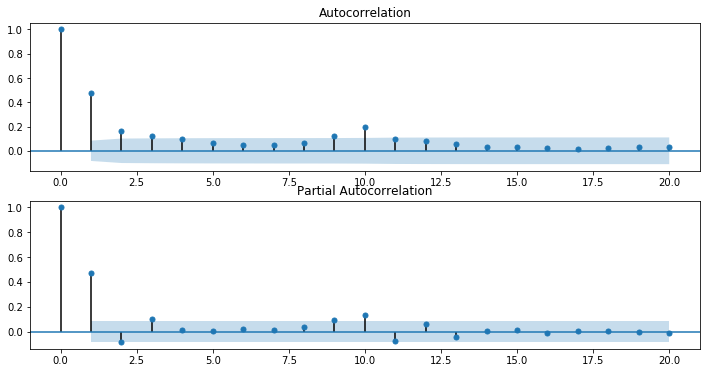

In [10]:
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df.Data.dropna(), ax=ax[0], lags=20)
ax[1] = plot_pacf(df.Data.dropna(), ax=ax[1], lags=20)

<a id="33" ></a> <br>
## <div>Properties and types of series</div>
---------------------------------------------------------------------

[go to top](#top)

Trend : A long-term increase or decrease in the data. This can be seen as a slope (is doesn’t have to be linear) roughly going through the data.

Seasonality : A time series is said to be seasonal when it is affected by seasonal factors (hour of day, week, month, year, etc.). Seasonality can be observed with nice cyclical patterns of fixed frequency.

Cyclicity : A cycle occurs when the data exhibits rises and falls that are not of a fixed frequency. These fluctuations are usually due to economic conditions, and are often related to the “business cycle”. The duration of these fluctuations is usually at least 2 years.

Residuals : Each time series can be decomposed in two parts:
- A forecast, made up of one or several forecasted values
- Residuals. They are the difference between an observation and its predicted value at each time step. Remember that

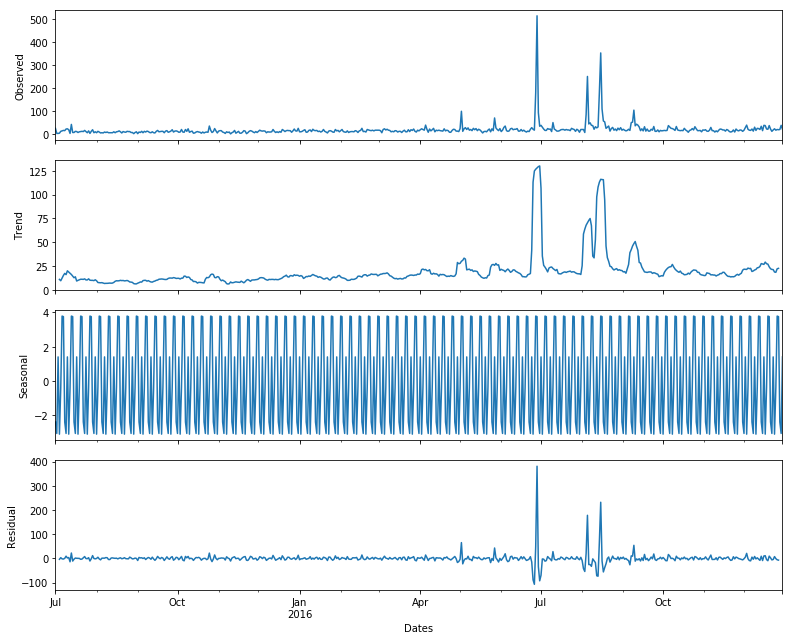

In [11]:
rcParams['figure.figsize'] = 11, 9

result = seasonal_decompose(df, model='additive')
result.plot()
plt.show()

<a id="4" ></a> <br>
## <div align="center">4. Choosing a model</div>
---------------------------------------------------------------------

[go to top](#top)

<a id="41" ></a> <br>
## <div>Train - test split</div>
---------------------------------------------------------------------

[go to top](#top)

In [12]:
print('Min Date: {}'.format(min(df.index)))
print('\n')
print('Max Date: {}'.format(max(df.index)))
print('\n')
print('Number of abservations: {}'.format(len(df)))
print('\n')
print('67 % train has {} rows'.format(np.round(len(df)*0.67)))
print('\n')
print('Cutting date: {}'.format(datetime(2015, 7, 1) + timedelta(days=368)))
print('\n')
print('33 % test has {} rows'.format(datetime(2016, 12, 31) - datetime(2016, 7, 3)))

Min Date: 2015-07-01 00:00:00


Max Date: 2016-12-30 00:00:00


Number of abservations: 549


67 % train has 368.0 rows


Cutting date: 2016-07-03 00:00:00


33 % test has 181 days, 0:00:00 rows


In [13]:
train_size = 0.67
cut = int(train_size*(len(df)))
train = df[:cut]
test = df[cut:]

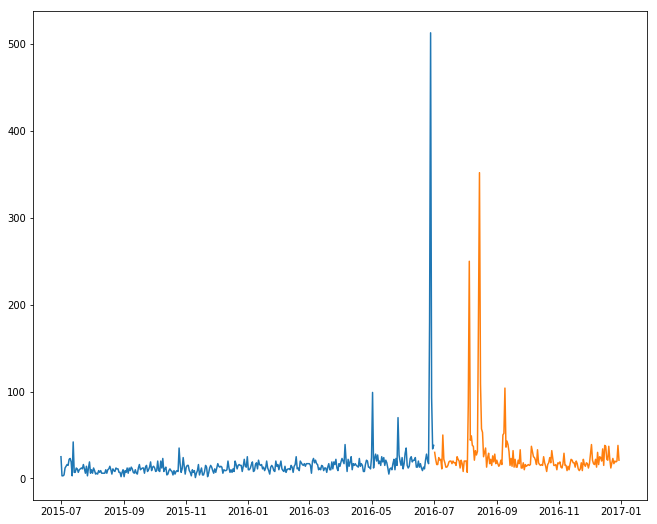

In [14]:
plt.plot(train)
plt.plot(test);

<a id="42" ></a> <br>
## <div>ARIMA</div>
---------------------------------------------------------------------

[go to top](#top)

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a class of model that captures a suite of different standard temporal structures in time series data.

* AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
* I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
* MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

* p: The number of lag observations included in the model, also called the lag order.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.

                              ARMA Model Results                              
Dep. Variable:                   Data   No. Observations:                  549
Model:                     ARMA(1, 3)   Log Likelihood               -2591.582
Method:                       css-mle   S.D. of innovations             27.143
Date:                Mon, 03 Jun 2019   AIC                           5195.165
Time:                        10:21:49   BIC                           5221.013
Sample:                    07-01-2015   HQIC                          5205.267
                         - 12-30-2016                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.8025      5.007      3.755      0.000       8.989      28.616
ar.L1.Data     0.9890      0.010     95.633      0.000       0.969       1.009
ma.L1.Data    -0.4836      0.044    -11.047      0.0

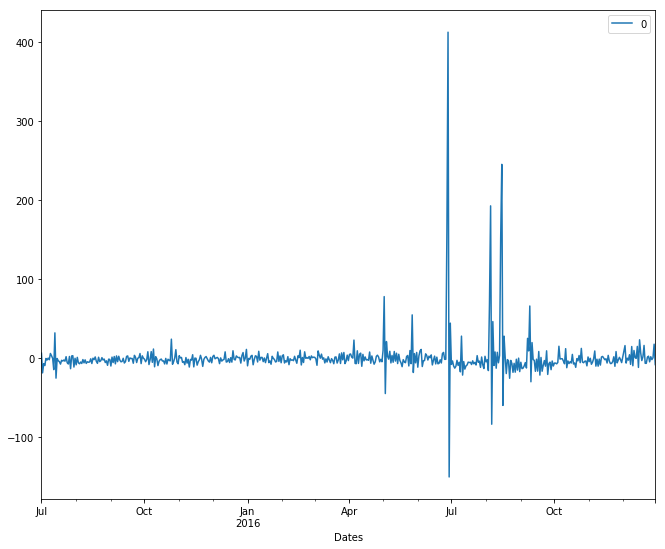

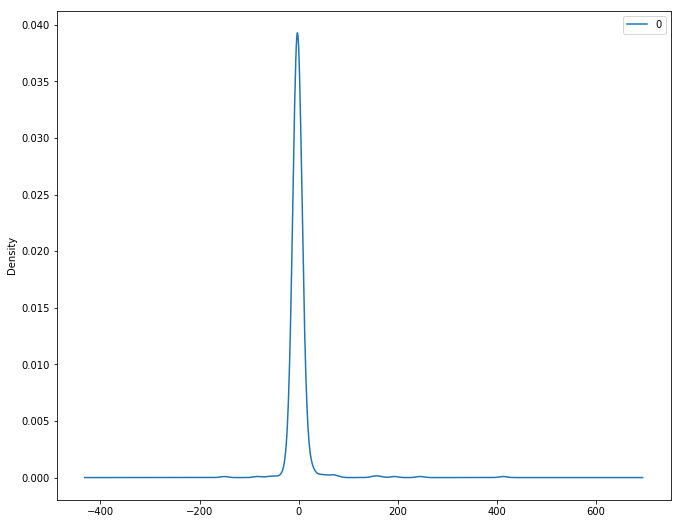

                0
count  549.000000
mean     0.203227
std     27.167907
min   -150.401004
25%     -6.117965
50%     -2.197520
75%      1.756117
max    412.481231


In [44]:
model = ARIMA(train, order=(1,0,3))
model_fit = model.fit(disp=0)

print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [45]:
start_index = '2016-07-03'
end_index = '2016-12-30'
future_forecast = model_fit.predict(start=start_index, end=end_index)

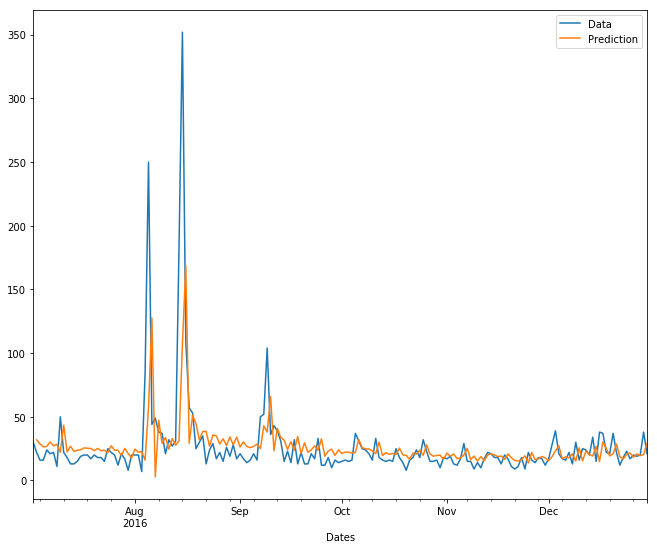

In [46]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
pd.concat([test,future_forecast],axis=1).plot()

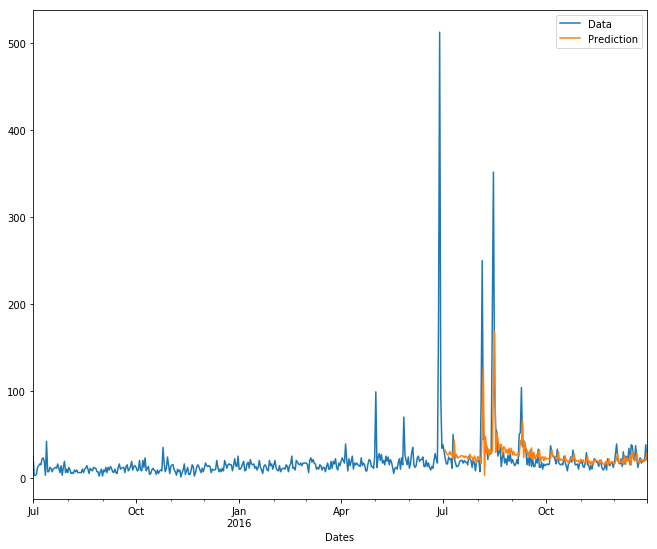

In [47]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
pd.concat([df,future_forecast],axis=1).plot()

### Auto-Arima

In [34]:
stepwise_model = auto_arima(df, start_p=1, start_q=1,
                           max_p=3, max_q=3,seasonal=False,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 0, 1); AIC=5201.845, BIC=5219.077, Fit time=0.092 seconds
Fit ARIMA: order=(0, 0, 0); AIC=5343.407, BIC=5352.023, Fit time=0.003 seconds
Fit ARIMA: order=(1, 0, 0); AIC=5205.863, BIC=5218.787, Fit time=0.034 seconds
Fit ARIMA: order=(0, 0, 1); AIC=5208.732, BIC=5221.656, Fit time=0.019 seconds
Fit ARIMA: order=(2, 0, 1); AIC=5202.629, BIC=5224.169, Fit time=0.176 seconds
Fit ARIMA: order=(1, 0, 2); AIC=5195.644, BIC=5217.184, Fit time=0.214 seconds
Fit ARIMA: order=(2, 0, 3); AIC=5195.612, BIC=5225.768, Fit time=0.427 seconds
Fit ARIMA: order=(1, 0, 3); AIC=5195.165, BIC=5221.013, Fit time=0.313 seconds
Fit ARIMA: order=(0, 0, 2); AIC=5203.843, BIC=5221.076, Fit time=0.038 seconds
Fit ARIMA: order=(0, 0, 3); AIC=5204.040, BIC=5225.580, Fit time=0.080 seconds
Total fit time: 1.396 seconds
5195.164551948084


<a id="43" ></a> <br>
## <div>Markov Switching</div>
---------------------------------------------------------------------

[go to top](#top)

In [59]:
MS = sm.tsa.MarkovAutoregression(train.Data, k_regimes=2, order=4, switching_ar=True)
res_MS = MS.fit()

res_MS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                     Data   No. Observations:                  545
Model:             MarkovAutoregression   Log Likelihood               -2508.770
Date:                  Mon, 03 Jun 2019   AIC                           5035.539
Time:                          10:34:13   BIC                           5074.246
Sample:                      07-01-2015   HQIC                          5050.671
                           - 12-30-2016                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         73.0527        nan        nan        nan         nan         nan
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        275.5591      2.607    105.688      0.000     270.449     280.669
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       546.2955    118.107      4.625      0.000     314.810     777.781
ar.L1          0.8474      0.062     13.679      0.000       0.726       0.969
ar.L2         -0.3582      0.096     -3.744      0.000      -0.546      -0.171
ar.L3         -0.1456      0.088     -1.653      0.098      -0.318       0.027
ar.L4          0.5976      0.100      5.960      0.000       0.401       0.794
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        1.0000   3.94e-06   2.53e+05      0.000       1.000       1.000
p[1->0]        1.0000      0.577      1.732      0.083      -0.132       2.132
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 8.98e+14. Standard errors may be unstable.
"""

In [66]:
start_index = '2016-07-03'
end_index = '2016-12-30'
future_forecast = res_MS.predict(start=start_index, end=end_index)

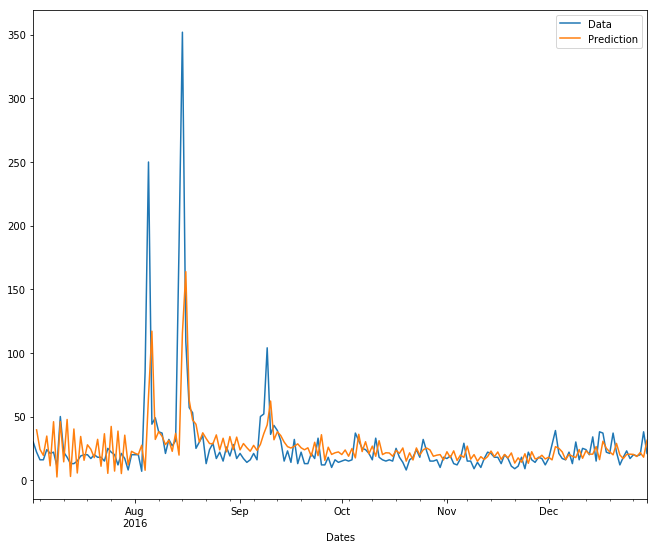

In [67]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
pd.concat([test,future_forecast],axis=1).plot()

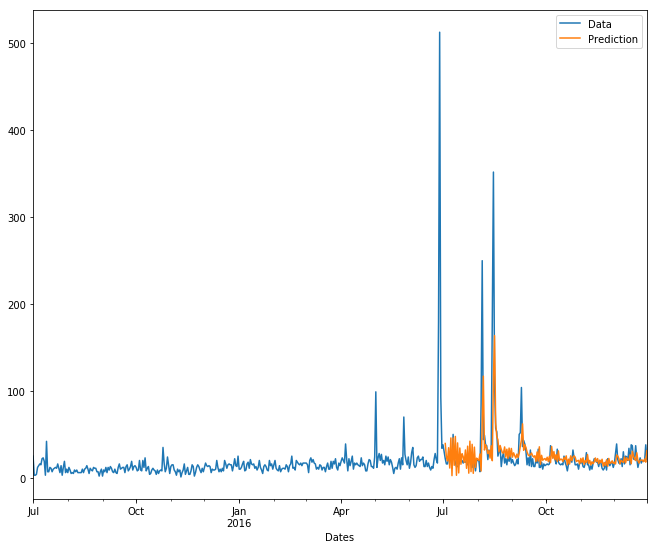

In [68]:
pd.concat([df,future_forecast],axis=1).plot()